# Named Entity Recognition using BiLSTM

## Brief Description

This project demonstrates the implementation of a Named Entity Recognition (NER) system using a Bidirectional Long Short-Term Memory (BiLSTM) model. The NER task aims to identify and classify named entities such as persons, organizations, locations, and miscellaneous entities within a given text. The BiLSTM model captures contextual information from both past and future tokens, enhancing the model's ability to recognize entities accurately.

### Key Steps:

1. **Data Preprocessing**: Tokenization, padding, label encoding, and one-hot encoding.
2. **Model Architecture**: Embedding layer, Bidirectional LSTM layer, TimeDistributed dense layer, and softmax output layer.
3. **Training**: Training the BiLSTM model on the CoNLL-2003 dataset.
4. **Evaluation**: Evaluating the model's performance using precision, recall, F1-score, and confusion matrix.
5. **Results**: Comparison of the BiLSTM model's performance with traditional methods and discussion of insights gained.


## Importing Libraries

In [ ]:
# Install necessary libraries (For Colab)
!pip install datasets tensorflow

In [75]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datasets import load_dataset
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.models import Model

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)


##  Loading and Preparing the Dataset

In [76]:
# Load the CoNLL-2003 dataset
dataset = load_dataset('conll2003')

def extract_data(dataset):
    """
    Extracts tokens, POS tags, and NER tags from the dataset.

    Args:
    dataset (Dataset): The dataset to extract data from.

    Returns:
    tuple: A tuple containing lists of tokens, POS tags, and NER tags.
    """
    tokens, pos_tags, ner_tags = [], [], []
    for example in dataset:
        tokens.append(example['tokens'])
        pos_tags.append(example['pos_tags'])
        ner_tags.append(example['ner_tags'])
    return tokens, pos_tags, ner_tags

train_data = dataset['train']
valid_data = dataset['validation']
test_data = dataset['test']

train_tokens, train_pos_tags, train_ner_tags = extract_data(train_data)
valid_tokens, valid_pos_tags, valid_ner_tags = extract_data(valid_data)
test_tokens, test_pos_tags, test_ner_tags = extract_data(test_data)


## Calculating Sequence Lengths

98th percentile length for training sequences: 42.0
98th percentile length for validation sequences: 44.0
98th percentile length for test sequences: 43.0
Max sequence length (98th percentile): 42


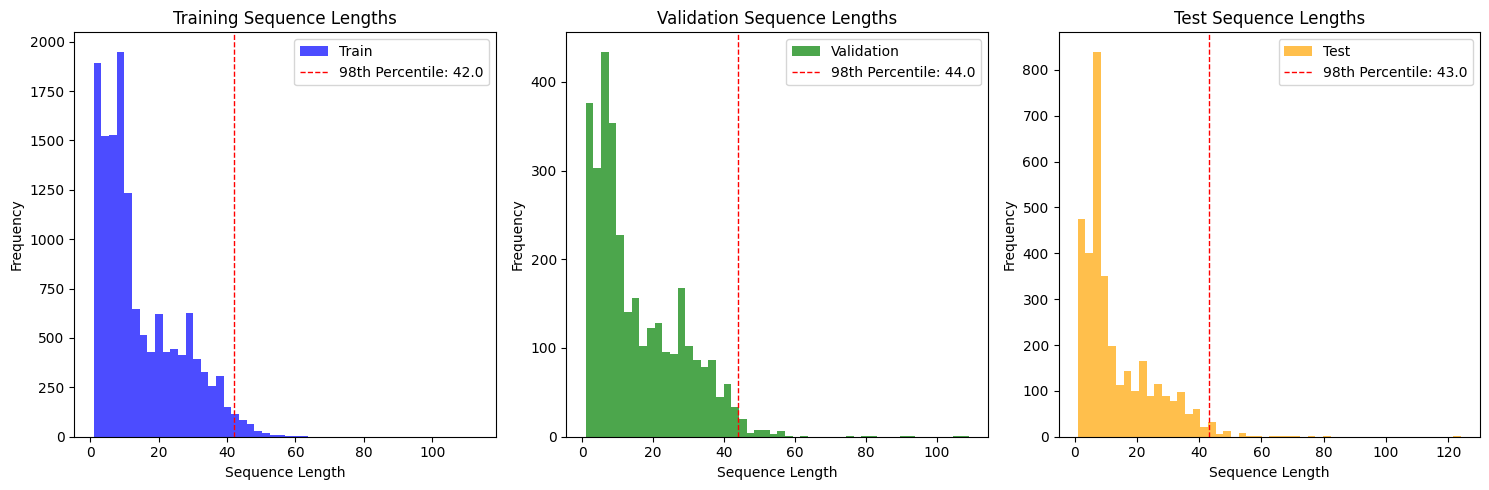

In [77]:
def calculate_lengths(sequences):
    """
    Calculates the lengths of sequences.

    Args:
    sequences (list): A list of sequences.

    Returns:
    list: A list of sequence lengths.
    """
    return [len(seq) for seq in sequences]

# Calculate lengths of sequences for train, validation, and test sets
train_lengths = calculate_lengths(train_tokens)
valid_lengths = calculate_lengths(valid_tokens)
test_lengths = calculate_lengths(test_tokens)

# # Display the lengths
# print("Training sequence lengths:", train_lengths[:10])
# print("Validation sequence lengths:", valid_lengths[:10])
# print("Test sequence lengths:", test_lengths[:10])

# Calculate the maximum lengths
max_train_len = max(train_lengths)
max_valid_len = max(valid_lengths)
max_test_len = max(test_lengths)

# print(f"Max length of training sequences: {max_train_len}")
# print(f"Max length of validation sequences: {max_valid_len}")
# print(f"Max length of test sequences: {max_test_len}")

def calculate_98th_percentile_length(lengths):
    """
    Calculates the 98th percentile length of sequences.

    Args:
    lengths (list): A list of sequence lengths.

    Returns:
    float: The 98th percentile length.
    """
    return np.percentile(lengths, 98)

# Calculate the 98th percentile length for the sequences
train_98th_len = calculate_98th_percentile_length(train_lengths)
valid_98th_len = calculate_98th_percentile_length(valid_lengths)
test_98th_len = calculate_98th_percentile_length(test_lengths)

# Use the maximum of the 98th percentile lengths for padding
min_seq_len = int(min(train_98th_len, valid_98th_len, test_98th_len))

print(f"98th percentile length for training sequences: {train_98th_len}")
print(f"98th percentile length for validation sequences: {valid_98th_len}")
print(f"98th percentile length for test sequences: {test_98th_len}")
print(f"Max sequence length (98th percentile): {min_seq_len}")

# Plot the lengths of sequences
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(train_lengths, bins=50, color='blue', alpha=0.7, label='Train')
plt.axvline(train_98th_len, color='red', linestyle='dashed', linewidth=1, label=f'98th Percentile: {train_98th_len}')
plt.title('Training Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(valid_lengths, bins=50, color='green', alpha=0.7, label='Validation')
plt.axvline(valid_98th_len, color='red', linestyle='dashed', linewidth=1, label=f'98th Percentile: {valid_98th_len}')
plt.title('Validation Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(test_lengths, bins=50, color='orange', alpha=0.7, label='Test')
plt.axvline(test_98th_len, color='red', linestyle='dashed', linewidth=1, label=f'98th Percentile: {test_98th_len}')
plt.title('Test Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


## Truncating Sequences

In [78]:
# Tokenizer for words
word_tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=False)
word_tokenizer.fit_on_texts(train_tokens)

def truncate_and_pad_sequences(sequences, max_len):
    """
    Truncates and pads sequences to a maximum length.

    Args:
    sequences (list): A list of sequences.
    max_len (int): The maximum length to truncate and pad the sequences to.

    Returns:
    np.array: An array of truncated and padded sequences.
    """
    return pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Truncate and pad sequences for train, validation, and test sets
train_sequences = truncate_and_pad_sequences(word_tokenizer.texts_to_sequences(train_tokens), min_seq_len)
valid_sequences = truncate_and_pad_sequences(word_tokenizer.texts_to_sequences(valid_tokens), min_seq_len)
test_sequences = truncate_and_pad_sequences(word_tokenizer.texts_to_sequences(test_tokens), min_seq_len)

# Prepare NER tag sequences
ner_tag_tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=False)
ner_tag_tokenizer.fit_on_texts(train_ner_tags)

train_ner_sequences = truncate_and_pad_sequences(ner_tag_tokenizer.texts_to_sequences(train_ner_tags), min_seq_len)
valid_ner_sequences = truncate_and_pad_sequences(ner_tag_tokenizer.texts_to_sequences(valid_ner_tags), min_seq_len)
test_ner_sequences = truncate_and_pad_sequences(ner_tag_tokenizer.texts_to_sequences(test_ner_tags), min_seq_len)

# Convert NER tag sequences to one-hot encoding
num_tags = len(ner_tag_tokenizer.word_index) + 1
train_ner_sequences = np.array([np.eye(num_tags)[seq] for seq in train_ner_sequences])
valid_ner_sequences = np.array([np.eye(num_tags)[seq] for seq in valid_ner_sequences])
test_ner_sequences = np.array([np.eye(num_tags)[seq] for seq in test_ner_sequences])

print("Training sequences after truncating and padding:", train_sequences.shape)
print("Validation sequences after truncating and padding:", valid_sequences.shape)
print("Test sequences after truncating and padding:", test_sequences.shape)


Training sequences after truncating and padding: (14041, 42)
Validation sequences after truncating and padding: (3250, 42)
Test sequences after truncating and padding: (3453, 42)


## Building the BiLSTM Model

In [175]:
def build_bilstm_model(max_seq_len, num_tags, vocab_size, embedding_dim=128, lstm_units=128, dropout_rate=0.1):
    """
    Builds a BiLSTM model for NER.

    Args:
    max_seq_len (int): The maximum sequence length.
    num_tags (int): The number of unique NER tags.
    vocab_size (int): The size of the vocabulary.
    embedding_dim (int, optional): The dimension of the embedding layer. 
    lstm_units (int, optional): The number of LSTM units. 
    dropout_rate (float, optional): The dropout rate. 

    Returns:
    Model: A compiled BiLSTM model.
    """
    input = Input(shape=(max_seq_len,))
    model = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_len)(input)
    model = Dropout(dropout_rate)(model)
    model = Bidirectional(LSTM(units=lstm_units, return_sequences=True, recurrent_dropout=dropout_rate))(model)
    model = TimeDistributed(Dense(lstm_units, activation="relu"))(model)
    out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)

    model = Model(input, out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

vocab_size = len(word_tokenizer.word_index) + 1
model_1 = build_bilstm_model(min_seq_len, num_tags, vocab_size)

model_1.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 42)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 42, 128)           3023872   
                                                                 
 dropout_3 (Dropout)         (None, 42, 128)           0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 42, 256)           263168    
 onal)                                                           
                                                                 
 time_distributed_7 (TimeDi  (None, 42, 128)           32896     
 stributed)                                                      
                                                                 
 time_distributed_8 (TimeDi  (None, 42, 10)            1290

## Setting Up Callbecks

In [176]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Define the learning rate scheduler and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


## Training the Model

In [177]:
history_1 = model_1.fit(
    train_sequences, train_ner_sequences,
    validation_data=(valid_sequences, valid_ner_sequences),
    batch_size=32,
    epochs=10,
    callbacks=[create_tensorboard_callback(dir_name="models_logs", # save experiment logs here
                                                            experiment_name="model_biltsm_ner"), lr_scheduler],
    verbose=1
)


Saving TensorBoard log files to: models_logs/model_biltsm_ner/20240719-162916
Epoch 1/10
439/439 [==============================] - 99s 212ms/step - loss: 0.2321 - accuracy: 0.9409 - val_loss: 0.7543 - val_accuracy: 0.9203 - lr: 0.0010
Epoch 2/10
439/439 [==============================] - 69s 156ms/step - loss: 0.0475 - accuracy: 0.9857 - val_loss: 0.8184 - val_accuracy: 0.9308 - lr: 0.0010
Epoch 3/10
439/439 [==============================] - 73s 167ms/step - loss: 0.0160 - accuracy: 0.9955 - val_loss: 0.8327 - val_accuracy: 0.9326 - lr: 0.0010
Epoch 4/10
439/439 [==============================] - 71s 161ms/step - loss: 0.0073 - accuracy: 0.9980 - val_loss: 0.8726 - val_accuracy: 0.9329 - lr: 0.0010
Epoch 5/10
439/439 [==============================] - 71s 161ms/step - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.9027 - val_accuracy: 0.9331 - lr: 5.0000e-04
Epoch 6/10
439/439 [==============================] - 89s 203ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.9320 - val_

## Plotting Training Curves

In [178]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    """
    Plots the training and validation loss and accuracy curves.

    Args:
    history (History): The history object returned by the fit method.
    """
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()



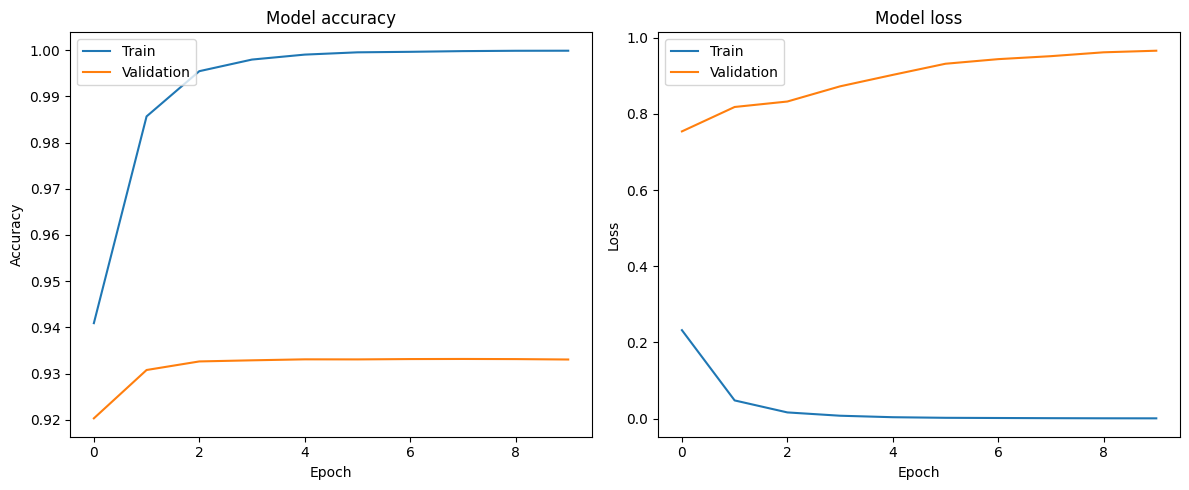

In [179]:
# Plot the training curves
plot_training_curves(history_1)


## Evaluating the Model

In [180]:
test_loss, test_accuracy = model_1.evaluate(test_sequences, test_ner_sequences)
print(f"Test Accuracy: {test_accuracy * 100 : 0.2f}%")


108/108 [==============================] - 3s 24ms/step - loss: 1.1099 - accuracy: 0.9233
Test Accuracy:  92.33%


## Calculate Precision, Recall and F1_score 

In [181]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
from sklearn.metrics import classification_report

def decode_predictions(preds, tokenizer):
    """
    Decodes the predictions from the model into readable labels.

    Args:
    preds (np.array): The raw predictions from the model.
    tokenizer (Tokenizer): The tokenizer used to encode the labels.

    Returns:
    list: A list of decoded predictions for the entire batch.
    """
    inverse_ner_map = {v: k for k, v in tokenizer.word_index.items()}
    inverse_ner_map[0] = 'O'  # Padding token
    decoded_preds = []
    for pred in preds:
        pred_labels = np.argmax(pred, axis=-1)
        decoded_preds.append([inverse_ner_map[tag] for tag in pred_labels])
    return decoded_preds

def decode_true_tags(true_tags, tokenizer):
    """
    Decodes the true tags from the one-hot encoding into readable labels.

    Args:
    true_tags (np.array): The true tags in one-hot encoded format.
    tokenizer (Tokenizer): The tokenizer used to encode the labels.

    Returns:
    list: A list of decoded true tags for the entire batch.
    """
    inverse_ner_map = {v: k for k, v in tokenizer.word_index.items()}
    inverse_ner_map[0] = 'O'  # Padding token
    decoded_true = []
    for true_tag_seq in true_tags:
        decoded_true.append([inverse_ner_map[tag] for tag in true_tag_seq])
    return decoded_true

# Make predictions on the entire test set
test_pred = loaded_model.predict(test_sequences)

# Decode the predictions for the entire test set
decoded_test_pred = decode_predictions(test_pred, ner_tag_tokenizer)

# Decode the true tags for the entire test set
true_tags_seq = test_ner_sequences.argmax(axis=-1)
decoded_true_tags = decode_true_tags(true_tags_seq, ner_tag_tokenizer)

# Flatten the lists for evaluation
flat_true = [item for sublist in decoded_true_tags for item in sublist]
flat_pred = [item for sublist in decoded_test_pred for item in sublist]

# Ensure that flat_true and flat_pred are of the same length
min_length = min(len(flat_true), len(flat_pred))
flat_true = flat_true[:min_length]
flat_pred = flat_pred[:min_length]

# Define the labels for the classification report
labels = list(ner_tag_tokenizer.word_index.keys())
if 'O' in labels:
    labels.remove('O')  # Remove the padding token if it exists

# Calculate and print classification report
print(classification_report(flat_true, flat_pred, labels=labels))


108/108 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

           0       0.91      0.84      0.87     37879
           5       0.44      0.40      0.42      1640
           1       0.54      0.30      0.39      1565
           3       0.66      0.51      0.58      1649
           2       0.54      0.16      0.25      1095
           4       0.68      0.46      0.55       816
           7       0.53      0.43      0.47       697
           6       0.51      0.39      0.44       254
           8       0.44      0.37      0.40       216

   micro avg       0.86      0.76      0.80     45811
   macro avg       0.58      0.43      0.49     45811
weighted avg       0.84      0.76      0.80     45811



## Saving the Model

In [182]:
def save_model(model, save_dir):
    """
    Saves the trained model to a specified directory.

    Args:
    model (Model): The trained Keras model.
    save_dir (str): The directory to save the model.
    """
    model.save(save_dir, save_format='tf')
    print(f"Model saved to {save_dir}")

# Specify the directory to save the model
save_directory = 'saved_models/bilstm_ner'

# Save the model
save_model(model_1, save_directory)


INFO:tensorflow:Assets written to: saved_models/bilstm_ner/assets


INFO:tensorflow:Assets written to: saved_models/bilstm_ner/assets


Model saved to saved_models/bilstm_ner


## Download model from colab

In [ ]:
import os
from google.colab import files

# Compress the model directory
!zip -r bilstm_ner_model.zip saved_models/bilstm_ner

# Download the compressed file
files.download('bilstm_ner_model.zip')

## Load The Model

In [183]:
import tensorflow as tf

def load_trained_model(save_dir):
    """
    Loads a trained model from a specified directory.

    Args:
    save_dir (str): The directory from which to load the model.

    Returns:
    Model: The loaded Keras model.
    """
    return tf.keras.models.load_model(save_dir, custom_objects={"tf": tf})

# Load the model
loaded_model = load_trained_model('saved_models/bilstm_ner')

# Check if the model loaded correctly by printing the summary
loaded_model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 42)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 42, 128)           3023872   
                                                                 
 dropout_3 (Dropout)         (None, 42, 128)           0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 42, 256)           263168    
 onal)                                                           
                                                                 
 time_distributed_7 (TimeDi  (None, 42, 128)           32896     
 stributed)                                                      
                                                                 
 time_distributed_8 (TimeDi  (None, 42, 10)            1290

## Predicting and Visualizing the Results

### Predicting on Sentence From test_data

In [184]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import random

def preprocess_sentence(sentence, tokenizer, max_seq_len):
    """
    Preprocesses a sentence for prediction by the model.

    Args:
    sentence (str): The input sentence to preprocess.
    tokenizer (Tokenizer): The tokenizer used to preprocess the training data.
    max_seq_len (int): The maximum sequence length for padding.

    Returns:
    np.array: The preprocessed and padded sequence.
    list: The original tokens.
    """
    tokens = sentence.split()
    tokenized_seq = tokenizer.texts_to_sequences([tokens])
    padded_seq = pad_sequences(tokenized_seq, maxlen=max_seq_len, padding='post', truncating='post')
    return padded_seq, tokens

def decode_single_prediction(pred, tokenizer):
    """
    Decodes the prediction from the model into readable labels.

    Args:
    pred (np.array): The raw prediction from the model.
    tokenizer (Tokenizer): The tokenizer used to encode the labels.

    Returns:
    list: A list of decoded predictions.
    """
    inverse_ner_map = {v: k for k, v in tokenizer.word_index.items()}
    inverse_ner_map[0] = 'O'  # Padding token
    pred_labels = np.argmax(pred, axis=-1)
    return [inverse_ner_map[tag] for tag in pred_labels[0]]

def get_prediction_as_dataframe(tokens, true_tags, pred_tags):
    """
    Returns the tokens with their true and predicted NER tags in a DataFrame.

    Args:
    tokens (list): The list of tokens in the input sentence.
    true_tags (list): The list of true NER tags.
    pred_tags (list): The list of predicted NER tags.
    
    Returns:
    pd.DataFrame: DataFrame containing tokens, true tags, and predicted tags.
    """
    data = {'Token': tokens, 'True Tag': true_tags, 'Predicted Tag': pred_tags}
    return pd.DataFrame(data)

# Randomly select a sentence from the test set
random_index = 11
random_test_sequence = test_sequences[random_index]
random_test_tokens = test_tokens[random_index]
random_test_true_tags = test_ner_tags[random_index]

# Make predictions on the selected test sentence
random_test_predicted_tags = loaded_model.predict(np.array([random_test_sequence]))

# Decode the predictions
decoded_prediction = decode_single_prediction(random_test_predicted_tags, ner_tag_tokenizer)

# Define the NER tags
ner_tags = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

# Create a dictionary for mapping
ner_tag_map = {tag: i for i, tag in enumerate(ner_tags)}

# Invert the dictionary for mapping back
inverse_ner_tag_map = {i: tag for tag, i in ner_tag_map.items()}

# Map decoded predictions to the specified NER tags
mapped_predictions = [inverse_ner_tag_map.get(tag, 'O') for tag in decoded_prediction]

# Get the results as a DataFrame
result_df = get_prediction_as_dataframe(random_test_tokens, random_test_true_tags, mapped_predictions[:len(random_test_tokens)])

# Display the DataFrame
result_df


1/1 [==============================] - 1s 502ms/step


,Token,True Tag,Predicted Tag
0,It,0,O
1,was,0,O
2,the,0,O
3,second,0,O
4,costly,0,O
5,blunder,0,O
6,by,0,O
7,Syria,5,B-LOC
8,in,0,O
9,four,0,O


### Predicting on Created Sentence

In [185]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd

def preprocess_sentence(sentence, tokenizer, max_seq_len):
    """
    Preprocesses a sentence for prediction by the model.

    Args:
    sentence (str): The input sentence to preprocess.
    tokenizer (Tokenizer): The tokenizer used to preprocess the training data.
    max_seq_len (int): The maximum sequence length for padding.

    Returns:
    np.array: The preprocessed and padded sequence.
    list: The original tokens.
    """
    tokens = sentence.split()
    tokenized_seq = tokenizer.texts_to_sequences([tokens])
    padded_seq = pad_sequences(tokenized_seq, maxlen=max_seq_len, padding='post', truncating='post')
    return padded_seq, tokens

def decode_single_prediction(pred, tokenizer):
    """
    Decodes the prediction from the model into readable labels.

    Args:
    pred (np.array): The raw prediction from the model.
    tokenizer (Tokenizer): The tokenizer used to encode the labels.

    Returns:
    list: A list of decoded predictions.
    """
    inverse_ner_map = {v: k for k, v in tokenizer.word_index.items()}
    inverse_ner_map[0] = 'O'  # Padding token
    pred_labels = np.argmax(pred, axis=-1)
    return [inverse_ner_map[tag] for tag in pred_labels[0]]

def get_prediction_as_dataframe(tokens, true_tags, pred_tags):
    """
    Returns the tokens with their true and predicted NER tags in a DataFrame.

    Args:
    tokens (list): The list of tokens in the input sentence.
    true_tags (list): The list of true NER tags.
    pred_tags (list): The list of predicted NER tags.
    
    Returns:
    pd.DataFrame: DataFrame containing tokens, true tags, and predicted tags.
    """
    data = {'Token': tokens, 'True Tag': true_tags, 'Predicted Tag': pred_tags}
    return pd.DataFrame(data)

# Example sentence
sentence = "John lives in New York and works at Google"

# True tags for the example sentence (replace with actual true tags)
true_tags = ['B-PER', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'O', 'B-ORG']

# Preprocess the sentence
preprocessed_sentence, original_tokens = preprocess_sentence(sentence, word_tokenizer, min_seq_len)

# Make predictions on the preprocessed sentence
predicted_tags = loaded_model.predict(preprocessed_sentence)

# Decode the predictions
decoded_prediction = decode_single_prediction(predicted_tags, ner_tag_tokenizer)

# Define the NER tags
ner_tags = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

# Create a dictionary for mapping
ner_tag_map = {tag: i for i, tag in enumerate(ner_tags)}

# Invert the dictionary for mapping back
inverse_ner_tag_map = {i: tag for tag, i in ner_tag_map.items()}

# Map decoded predictions to the specified NER tags
mapped_predictions = [inverse_ner_tag_map.get(tag, 'O') for tag in decoded_prediction]

# Get the results as a DataFrame
result_df = get_prediction_as_dataframe(original_tokens, true_tags, mapped_predictions[:len(original_tokens)])

# Display the DataFrame
result_df


1/1 [==============================] - 0s 44ms/step


,Token,True Tag,Predicted Tag
0,John,B-PER,B-PER
1,lives,O,O
2,in,O,O
3,New,B-LOC,B-LOC
4,York,I-LOC,I-LOC
5,and,O,O
6,works,O,O
7,at,O,O
8,Google,B-ORG,O
